# Ames Housing Project 

## Data Cleaning
- Decide how to impute null values.
- Decide how to handle outliers.
- Do you want to combine any features?
- Do you want to have interaction terms?
- Do you want to manually drop collinear features?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

%matplotlib inline

In [2]:
#Get datasets: NB, test is just read but will not be written over until modelling is done
test = '../datasets/test.csv'
train = '../datasets/train.csv'

In [3]:
test = pd.read_csv(test)
train = pd.read_csv(train)

In [4]:
#Annotate test and train sets
df = pd.concat([test,train],ignore_index=True,sort=False)
y = df['SalePrice']

In [5]:
# Remove PID and ID as columns as they are redundant
df = df.drop(labels =['Id','PID'],axis = 1)

In [6]:
df.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,NaN
1,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2006,WD,NaN
2,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,New,NaN
3,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,7,2007,WD,NaN
4,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,Inside,...,185,0,NaN,NaN,NaN,0,7,2009,WD,NaN


In [7]:
# Checking for nulls
df.isnull().sum().sort_values().tail(30)

##no. nulls similar columns might be related.

##From data dictionary, there are columns with NA columns to signify the absence of the additional ammenities
# Pandas dataframe automatically considers all NA columns as NaN, whereas the columns are actually a category by itself
#Need to check and replace all columns that are not in actual fact <blank>/missing

Exterior 2nd         0
Year Remod/Add       0
BsmtFin SF 1         1
BsmtFin SF 2         1
Electrical           1
Bsmt Unf SF          1
Total Bsmt SF        1
Garage Area          1
Garage Cars          1
Bsmt Full Bath       2
Bsmt Half Bath       2
Mas Vnr Area        23
Mas Vnr Type        23
BsmtFin Type 1      80
Bsmt Cond           80
Bsmt Qual           80
BsmtFin Type 2      81
Bsmt Exposure       83
Garage Type        157
Garage Qual        159
Garage Finish      159
Garage Yr Blt      159
Garage Cond        159
Lot Frontage       490
SalePrice          879
Fireplace Qu      1422
Fence             2358
Alley             2732
Misc Feature      2824
Pool QC           2917
dtype: int64

In [8]:
# If BsmtFin SF 1, SF 2 and total bsmt SF are NaN, total square feet (numeric) should be 0.
df[df['BsmtFin SF 1'].isnull()][['BsmtFin SF 1','Total Bsmt SF', 'BsmtFin SF 2', 'Bsmt Unf SF']]

,BsmtFin SF 1,Total Bsmt SF,BsmtFin SF 2,Bsmt Unf SF
2206,NaN,NaN,NaN,NaN


In [9]:
df=df.fillna({'BsmtFin SF 1':0, 'Total Bsmt SF': 0, 'BsmtFin SF 2':0,'Bsmt Unf SF':0})

In [10]:
# Null in Garage Area linked to null in garage cars
df[df['Garage Area'].isnull()][['Garage Cars']]

,Garage Cars
2591,NaN


In [11]:
# Garage area and car should be set to integer '0' if NaN.
df=df.fillna({'Garage Area':0,'Garage Cars':0})

In [12]:
# Null in electrical is linked to utilities; check has electricity
df[df['Electrical'].isnull()][['Electrical','Utilities']]

,Electrical,Utilities
635,NaN,AllPub


In [13]:
# Most houses with All Pub utilities, electrical holds standard breaker
df[df['Utilities'] == 'AllPub']['Electrical'].value_counts()

SBrkr    2682
FuseA     185
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [14]:
# Replace index 635 electrical with SBrkr
df.loc[635,'Electrical'] = 'SBrkr'

In [15]:
# Bsmt half or full bathroom, if NaN --> Set to 0.0
df=df.fillna({'Bsmt Half Bath':0.0, 'Bsmt Full Bath': 0.0})

In [16]:
# Masonry veneer type if NaN, set to None
# Masonry veneer area if NaN, set to '0'
df=df.fillna({'Mas Vnr Type':'None', 'Mas Vnr Area': 0.0})

In [17]:
#column in basment finish type 2 empty but not empty in type 1 check index number
df[df['BsmtFin Type 2'].isnull()]['BsmtFin Type 1'].sort_values(ascending = True).head()

2026    GLQ
15      NaN
37      NaN
77      NaN
79      NaN
Name: BsmtFin Type 1, dtype: object

In [18]:
df.loc[2026,['Bsmt Cond','Bsmt Qual','BsmtFin Type 1','BsmtFin Type 2','Bsmt Exposure']]

Bsmt Cond          TA
Bsmt Qual          Gd
BsmtFin Type 1    GLQ
BsmtFin Type 2    NaN
Bsmt Exposure      No
Name: 2026, dtype: object

In [19]:
# For most cases, when Bsmt cond = TA, quality = Gd, finish type 1 = GLQ and bsmt exposure = no, BsmtFin Type 2 is Unf
basement = df[(df['Bsmt Cond'] == 'TA') & (df['Bsmt Qual'] == 'Gd') & (df['BsmtFin Type 1'] == 'GLQ') & (df['Bsmt Exposure'] == 'No')].mode()
basement[['BsmtFin Type 2']].head(2)

,BsmtFin Type 2
0,Unf
1,NaN


In [20]:
df.loc[2026,'BsmtFin Type 2'] = 'Unf'

In [21]:
# For cases where exposure is null, There are values in basment condition, quality and finish type 1 and 2 in indices 2335, 2426 and 2876
df[df['Bsmt Exposure'].isnull()]['BsmtFin Type 2'].sort_values(ascending = True).head()

2335    Unf
2426    Unf
2876    Unf
15      NaN
37      NaN
Name: BsmtFin Type 2, dtype: object

In [22]:
# three cases, Cond = TA, Qual = Gd, Type 1 and 2 = Unf, mode of Bsmt Exposure to replace this three cases
basement = df[(df['Bsmt Cond'] == 'TA') & (df['Bsmt Qual'] == 'Gd') & (df['BsmtFin Type 1'] == 'Unf') & (df['BsmtFin Type 2'] == 'Unf')].mode()
basement[['Bsmt Exposure']].head(2)

,Bsmt Exposure
0,No
1,NaN


In [23]:
# Replace all 3 cases with exposure as 'No'
replacement = [2335, 2426, 2876]
for row in replacement:
    df.loc[row,'Bsmt Exposure'] = 'No'

In [24]:
# BsmtFin Type 1 and Type 2, Bsmt Qual, Cond and Exposure if NaN, set to "None"
df=df.fillna({'BsmtFin Type 1':'None',
              'BsmtFin Type 2':'None',
              'Bsmt Qual':'None',
              'Bsmt Cond':'None',
              'Bsmt Exposure':'None'
             })

In [25]:
# isnull for Garage type != Garage qual/cond/fin ----> 157 != 159;
# There is a row with garage type = Detchd but no quality, condition, finish and yr Belt
df[df['Garage Qual'].isnull()]['Garage Type'].sort_values(ascending = True).head(3)

765     Detchd
2591    Detchd
29         NaN
Name: Garage Type, dtype: object

In [26]:
# Show mode of Garage Qual, Cond, Finish and Yr Blt when Garage type == Detchd
garage = df[df['Garage Type'] == 'Detchd'].mode()
garage[['Garage Qual','Garage Cond','Garage Finish', 'Garage Yr Blt']].head()

,Garage Qual,Garage Cond,Garage Finish,Garage Yr Blt
0,TA,TA,Unf,1950.0
1,NaN,NaN,NaN,NaN


In [27]:
#For Garage type of 'Detached':
# Replace garage quality, condition, finish and year built of index 1712 with mode of each column
replacements = [765,2591]
for i in replacements:
    df.loc[i,'Garage Qual'] = 'TA'
    df.loc[i,'Garage Cond'] = 'TA'
    df.loc[i,'Garage Finish'] = 'Unf'
    df.loc[i,'Garage Yr Blt'] = 1950.0

In [28]:
df[['Garage Yr Blt']].mean()

Garage Yr Blt    1978.112153
dtype: float64

In [29]:
# Garage Type, Qual, Cond, Finish set to 'None' if NaN
# Garage Yr Blt set to mean to preserve mean year built
df=df.fillna({'Garage Type':'None',
              'Garage Qual':'None',
              'Garage Cond':'None',
              'Garage Finish':'None',
              'Garage Yr Blt':1978
             })

In [30]:
# Unusual data year 2207; to correct to 2007
df['Garage Yr Blt'].sort_values(ascending = False).head(3)

2578    2207.0
317     2010.0
453     2010.0
Name: Garage Yr Blt, dtype: float64

In [31]:
# Correcting year 2207 as 2007
df.loc[2578,'Garage Yr Blt'] = 2007.0

In [32]:
# For lot frontage, if NaN, replace value with 0.0 
df=df.fillna({'Lot Frontage': 0.0})

In [33]:
# For Fireplace quality, if fireplace = 0, quality should be 'None' 
df=df.fillna({'Fireplace Qu': 'None'})

In [34]:
# For Fence if NaN, should be 'None' 
df=df.fillna({'Fence': 'None'})

In [35]:
# For Alley if NaN, should be 'None' 
df=df.fillna({'Alley': 'None'})

In [36]:
# For Misc features, if NaN, should be 'None' 
df=df.fillna({'Misc Feature': 'None'})

In [37]:
# For Pool QC, if Pool = 0, quality should be 'None' 
df=df.fillna({'Pool QC': 'None'})

In [38]:
df.isnull().sum().sort_values(ascending = False).head()

SalePrice       879
Foundation        0
Roof Matl         0
Exterior 1st      0
Exterior 2nd      0
dtype: int64

In [39]:
#Setting ordinal categories
ordered_shape = ['IR3', 'IR2', 'IR1', 'Reg']
ordered_utilities = ['ELO','NoSeWa','NoSewr','AllPub']
ordered_slope = ['Sev','Mod','Gtl']
ordered_quality = ['None','Po','Fa','TA','Gd','Ex']
ordered_exposure = ['None','No','Mn','Av','Gd']
ordered_bsmt_finish = ['None','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
ordered_electrical = ['Mix','FuseP','FuseF','FuseA','SBrkr']
ordered_functional = ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ']
ordered_garage_finish = ['None','Unf','RFn','Fin']
ordered_paved = ['N','P','Y']
ordered_fence = ['None','MnWw','GdWo','MnPrv','GdPrv']

In [40]:
#All ordinal columns
ordinal_cols = ['Lot Shape','Utilities','Land Slope','Exter Qual','Exter Cond',
                'Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2',
                'Heating QC','Electrical','Kitchen Qual','Functional','Fireplace Qu',
               'Garage Finish','Garage Qual','Garage Cond','Paved Drive','Pool QC','Fence']

In [41]:
#Changing type to category for ordinal columns and value from data dictionary
df['Lot Shape'] = df['Lot Shape'].astype("category",ordered=True,categories=ordered_shape).cat.codes
df['Utilities'] = df['Utilities'].astype("category",ordered=True,categories=ordered_utilities).cat.codes
df['Land Slope'] = df['Land Slope'].astype("category",ordered=True,categories=ordered_slope).cat.codes
df['Exter Qual'] = df['Exter Qual'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Exter Cond'] = df['Exter Cond'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Bsmt Qual'] = df['Bsmt Qual'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Bsmt Cond'] = df['Bsmt Cond'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Bsmt Exposure'] = df['Bsmt Exposure'].astype("category",ordered=True,categories=ordered_exposure).cat.codes
df['BsmtFin Type 1'] = df['BsmtFin Type 1'].astype("category",ordered=True,categories=ordered_bsmt_finish).cat.codes
df['BsmtFin Type 2'] = df['BsmtFin Type 2'].astype("category",ordered=True,categories=ordered_bsmt_finish).cat.codes
df['Heating QC'] = df['Heating QC'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Electrical'] = df['Electrical'].astype("category",ordered=True,categories=ordered_electrical).cat.codes
df['Kitchen Qual'] = df['Kitchen Qual'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Functional'] = df['Functional'].astype("category",ordered=True,categories=ordered_functional).cat.codes
df['Fireplace Qu'] = df['Fireplace Qu'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Garage Finish'] = df['Garage Finish'].astype("category",ordered=True,categories=ordered_garage_finish).cat.codes
df['Garage Qual'] = df['Garage Qual'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Garage Cond'] = df['Garage Cond'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Paved Drive'] = df['Paved Drive'].astype("category",ordered=True,categories=ordered_paved).cat.codes
df['Pool QC'] = df['Pool QC'].astype("category",ordered=True,categories=ordered_quality).cat.codes
df['Fence'] = df['Fence'].astype("category",ordered=True,categories=ordered_fence).cat.codes


C:\Users\n3rDx\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  exec(code_obj, self.user_global_ns, self.user_ns)


In [42]:
# Mapping categories with only 2 unique groups
df['Central Air'] = df['Central Air'].map({'Y':1,'N':0})
df['Street'] = df['Street'].map({'Grvl':1,'Pave':0})

In [43]:
# All nominal columns
nom_cols = df.columns[df.dtypes == 'object']
# All continuous columns
cont_cols = ['Lot Frontage','Lot Area','Mas Vnr Area','BsmtFin SF 1','BsmtFin SF 2',
           'Bsmt Unf SF','Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area','Wood Deck SF',
           'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area','Misc Val']
# All discrete columns
dist_cols = [ 'Bsmt Full Bath','Bsmt Half Bath','Full Bath','Half Bath','Bedroom AbvGr', 'Kitchen AbvGr','TotRms AbvGrd','Fireplaces','Garage Cars','Mo Sold','Yr Sold']
# All year/time related columns
time_cols = ['Year Built','Year Remod/Add','Garage Yr Blt']

In [44]:
#Looking at scatterplots and checking for outliers:
def subplot_scatter(df,list_of_titles, list_of_xlabels):
    ncols = 4
    nrows = int(np.ceil(len(df.columns) / (1.0*ncols)))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 25))
    counter = 0
    for i in range(nrows):
        for j in range(ncols):
            ax = axes[i][j]  
            if counter < len(df.columns):      # Plot when we have data
                ax.scatter(df[df.columns[counter]], y)
                ax.set_xlabel(list_of_xlabels[counter])
                ax.set_title(list_of_titles[counter])
                ax.set_ylabel("Price")
        # Remove axis when we no longer have data
            else:
                ax.set_axis_off()
            counter += 1
    plt.tight_layout()
    plt.show()

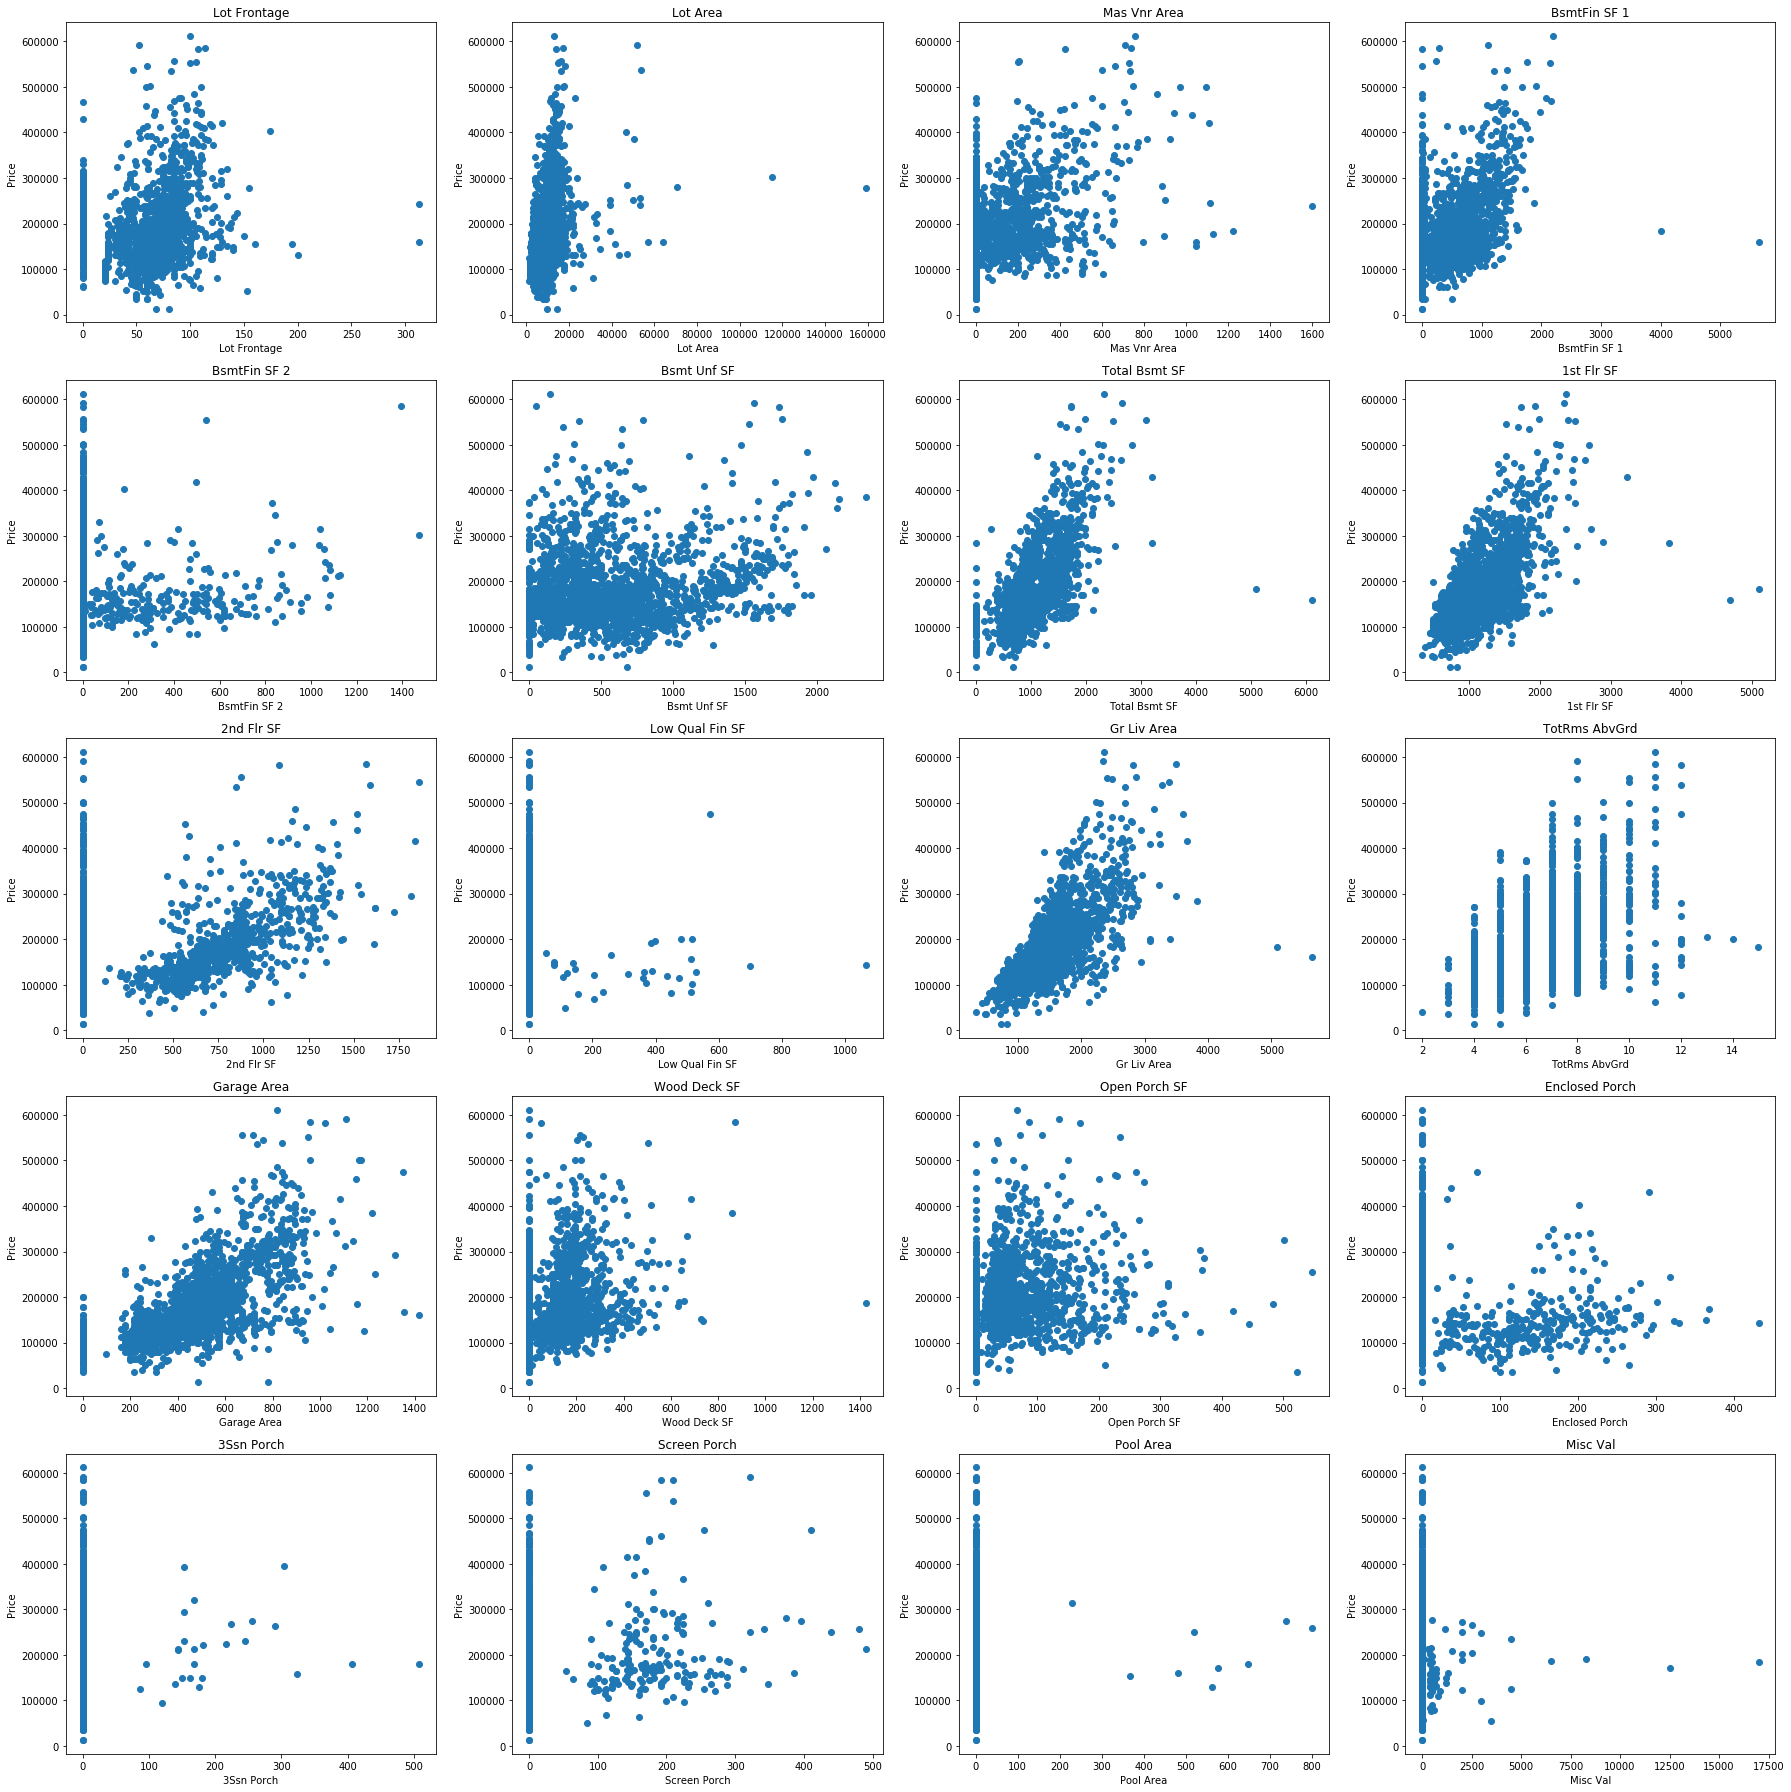

In [45]:
## Look at scatter plots to spot the outliers
subplot_scatter(df[cont_cols],cont_cols,cont_cols)

In [46]:
# Following documentation, as seen that there are 5 outliers, we will follow suit as seen from the scatter plot in Gr Liv Area.
df[df['Gr Liv Area'] >= 4000].index

Int64Index([76, 171, 464, 1839, 2764], dtype='int64')

In [47]:
# To remove outliers with living area >= 4000 Sq Ft
df.drop(df[df['Gr Liv Area'] >= 4000].index, inplace = True)

In [48]:
# Split test and train set again after cleaning
test = df[df['SalePrice'].isnull()]
train = df[df['SalePrice'].notnull()]

In [49]:
train.to_csv('../datasets/train_cleaned.csv')
test.to_csv('../datasets/test_cleaned.csv')

In [50]:
# Onto manipulation of features